In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from datetime import timezone
from zipfile import ZipFile
import os

In [2]:
urls = pd.read_csv('data/news/urls_with_unique_titles_fasttext.csv', index_col=0)

In [3]:
def make_df(start_time, end_time):
    timestamps = sorted(os.listdir('data/news/timestamps'))
    start_timestamp, end_timestamp = make_timestamps_from_datetime(start_time, end_time, timestamps)
    interval = make_interval(start_timestamp, end_timestamp, timestamps)
    with ZipFile('data/news/timestamps.zip') as timestamps_zip:
        df_list = [pd.read_csv(timestamps_zip.open("timestamps/" + file), header=None, names=['fullVisitorId', 'url_id', 'visitStartTime']) for file in interval]
    df = pd.concat(df_list)
    labels, levels = pd.factorize(df['fullVisitorId'])
    df['user_id'] = labels
    return df


# first = 12/03/2017 07:00:00(1491818423), last = 14/04/2017(1491991225) 11:11:29
def make_timestamps_from_datetime(start_time, end_time, timestamps):
    if start_time == 'first':
        start_timestamp = timestamps[0]
    else:
        start_datetime = datetime.strptime(start_time, '%d/%m/%Y %H:%M:%S')
        start_timestamp = (start_datetime - datetime(1970, 1, 1)).total_seconds()
        
    if end_time == 'last':
        end_timestamp = timestamps[-1]
    else:
        end_datetime = datetime.strptime(end_time, '%d/%m/%Y %H:%M:%S')
        end_timestamp = (end_datetime - datetime(1970, 1, 1)).total_seconds()
    return (start_timestamp, end_timestamp)


def make_interval(start_timestamp, end_timestamp, timestamps):
    start_timestamp = str(start_timestamp)
    end_timestamp = str(end_timestamp)
    interval = [t for t in timestamps if t >= start_timestamp and t <= end_timestamp]
    return interval


def merge_df(df, urls):
    urls['url_id'] = urls['url_id'].astype(int)
    urls['title'] = urls['title'].astype(str)
    
    df_result = pd.merge(df, urls, on='url_id', how='left')

    labels, levels = pd.factorize(df_result['url_id'])
    df_result['url_id'] = labels
    df_result.set_index(['user_id', 'url_id'], inplace=True)
    df_result.sort_index(inplace=True)
    df_result.dropna(how='any',inplace=True)
    df_result.drop_duplicates(inplace=True)
    
    df_result['fullVisitorId'] = df_result['fullVisitorId'].astype(str)
    df_result['title'] = df_result['title'].astype(str)
    df_result['pagePath'] = df_result['pagePath'].astype(str)

    return df_result

In [62]:
# You can choose time interval beetween 12/03/2017 07:00:00 and 14/04/2017 11:11:29
# Also you can use as arguments 'first' or 'last'
start_time = '11/04/2017 10:00:00'
end_time = '11/04/2017 11:00:0'

df = make_df(start_time, end_time)
df_result = merge_df(df, urls)

In [63]:
# Calculates user clicks score for each news article
scores = df_result['pagePath'].value_counts()
df_result['scores'] = df_result['pagePath'].apply(lambda path: scores[str(path)])

In [64]:
dataset = pd.DataFrame(df_result['scores']).reset_index()
dataset.columns = ['user_id', 'item_id', 'scores']
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
dataset.head(10)

,user_id,item_id,scores
0,0,0,5
1,0,117,74
2,0,132,33
3,0,132,33
4,0,206,27
5,0,375,104
6,0,689,130
7,0,1041,61
8,0,1041,61
9,1,1,3


In [65]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [66]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_urls = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

print("Users: {}, Urls: {}".format(n_users, n_urls))

Users: 44642, Urls: 4310


In [67]:
# Matrix factorisation model
url_input = keras.layers.Input(shape=[1],name='Item')
url_embedding = keras.layers.Embedding(n_urls + 1, n_latent_factors, name='Url-Embedding')(url_input)
url_vec = keras.layers.Flatten(name='FlattenUrls')(url_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

# prod = keras.layers.merge([url_vec, user_vec], mode='dot',name='DotProduct')
prod = keras.layers.dot([url_vec, user_vec], axes=1,name='DotProduct')
model_mf = keras.Model([user_input, url_input], prod)
model_mf.compile('adam', 'mean_squared_error')
model_mf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Url-Embedding (Embedding)       (None, 1, 3)         12933       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         133929      User[0][0]                       
__________________________________________________________________________________________________
FlattenUrl

In [68]:
history_mf = model_mf.fit([train.user_id, train.item_id], train.scores, epochs=15)

Epoch 1/15
79277/79277 [==============================] - 8s 97us/step - loss: 1827351.5767
Epoch 2/15
79277/79277 [==============================] - 7s 93us/step - loss: 1827130.4315
Epoch 3/15
79277/79277 [==============================] - 8s 101us/step - loss: 1826306.9980
Epoch 4/15
79277/79277 [==============================] - 9s 108us/step - loss: 1824862.6956
Epoch 5/15
79277/79277 [==============================] - 9s 109us/step - loss: 1822833.8644
Epoch 6/15
79277/79277 [==============================] - 9s 114us/step - loss: 1820227.0042
Epoch 7/15
63968/79277 [=======================>......] - ETA: 1s - loss: 1823958.3093

KeyboardInterrupt: 

In [71]:
# Neural networks model

n_latent_factors_user = 5
n_latent_factors_url = 8

url_input = keras.layers.Input(shape=[1],name='Item')
url_embedding = keras.layers.Embedding(n_urls + 1, n_latent_factors_url, name='Url-Embedding')(url_input)
url_vec = keras.layers.Flatten(name='FlattenUrls')(url_embedding)
url_vec = keras.layers.Dropout(0.2)(url_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.concatenate([url_vec, user_vec],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(128,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(64,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(32,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(16,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model_nn = keras.Model([user_input, url_input], result)
model_nn.compile(optimizer=adam,loss= 'mean_absolute_error')
model_nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Url-Embedding (Embedding)       (None, 1, 8)         34488       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         223215      User[0][0]                       
__________________________________________________________________________________________________
FlattenUrl

In [72]:
history_nn = model_nn.fit([train.user_id, train.item_id], train.scores, epochs=15)

Epoch 1/15
79277/79277 [==============================] - 13s 158us/step - loss: 147.1455
Epoch 2/15
79277/79277 [==============================] - 13s 166us/step - loss: 104.9458
Epoch 3/15
79277/79277 [==============================] - 15s 185us/step - loss: 99.7227
Epoch 4/15
79277/79277 [==============================] - 15s 183us/step - loss: 96.5192
Epoch 5/15
79277/79277 [==============================] - 15s 184us/step - loss: 95.2978
Epoch 6/15
79277/79277 [==============================] - 15s 186us/step - loss: 93.4066
Epoch 7/15
79277/79277 [==============================] - 15s 192us/step - loss: 93.1725
Epoch 8/15
79277/79277 [==============================] - 15s 188us/step - loss: 91.5309
Epoch 9/15
79277/79277 [==============================] - 15s 189us/step - loss: 91.4342
Epoch 10/15
79277/79277 [==============================] - 15s 189us/step - loss: 90.5114
Epoch 11/15
79277/79277 [==============================] - 15s 189us/step - loss: 68.1530
Epoch 12/15
79277

Text(0,0.5,'Train Error')

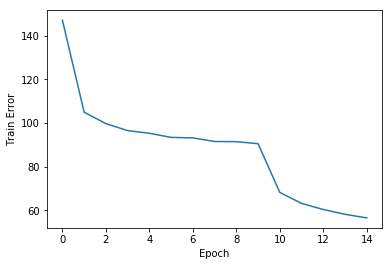

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.Series(history_nn.history['loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [75]:
from sklearn.metrics import mean_absolute_error
    
y_pred_nn = model_nn.predict([test.user_id, test.item_id])
y_true = test.scores
mse_nn = mean_absolute_error(y_true, y_pred_nn)
print('Neural networks MSE:', np.round(mse_nn, 5))

Neural networks MSE: 41.35734


In [79]:
print(y_pred_nn[:10])
print(y_true.values[:10])

[[  103.25749969]
 [  371.08828735]
 [  608.44421387]
 [ 1475.49401855]
 [   63.6507225 ]
 [   97.905159  ]
 [  812.54052734]
 [  297.09240723]
 [   96.86740112]
 [  856.87268066]]
[ 100  345  630 1513   69   94  789  266    2  861]
